# CsI Spectrum Analysis

In [3]:

import numpy as np
import scipy.io
import sys
import os

import pandas as pd
from numpy import pi, sin, cos, arcsin, sqrt, exp, arctan, tan
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.image as mpimg
import matplotlib.mlab as mlab
from matplotlib import colors, cm
from ipywidgets import *
from scipy import misc 
import scipy.io
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy import stats
from ROOT import TFile, TArray

# Set Flags

In [4]:
ROOTMAT_zerodiv = False; #Translate Root to mat files again (only once required) - energy mono only, zero divergence
ROOTMAT_vertdiv = False; #Translate Root to mat files again (only once required) - vertical divergence only
ROOTMAT_thetaphi = False; #Translate Root to mat files again (only once required) - spherical coordinates

# Reading in ROOT Files Zero Divergence

## Functions to read in ROOT files

In [5]:

def GetTH1D(hist):
    Nbinsx = hist.GetNbinsX()

    print("Size: " + str(Nbinsx))

    buf = np.frombuffer(hist.GetArray(), dtype='d', count=(Nbinsx+2))
    nphist = np.reshape(buf, Nbinsx+2)
    nphist = nphist[1:-1]

    xmin = hist.GetXaxis().GetXmin()
    xmax = hist.GetXaxis().GetXmax()
    dx = (xmax - xmin)/Nbinsx
    # Get bin centres from upper and lower edges
    nphistaxis = np.linspace(xmin+dx/2, xmax-dx/2, Nbinsx)

    return nphist, nphistaxis

def GetTH2D(hist):
    Nbinsx = hist.GetNbinsX()
    Nbinsy = hist.GetNbinsY()

    print("Size: " + str(Nbinsx) + ' x ' + str(Nbinsy))

    buf = np.frombuffer(hist.GetArray(), dtype='d', count=(Nbinsx+2)*(Nbinsy+2))
    nphist = np.reshape(buf, (Nbinsy+2, Nbinsx+2))
    nphist = nphist[1:-1, 1:-1]

    xmin = hist.GetXaxis().GetXmin()
    xmax = hist.GetXaxis().GetXmax()
    dx = (xmax - xmin)/Nbinsx
    # Get bin centres from upper and lower edges
    nphistxaxis = np.linspace(xmin+dx/2, xmax-dx/2, Nbinsx)

    ymin = hist.GetYaxis().GetXmin()
    ymax = hist.GetYaxis().GetXmax()
    dy = (ymax - ymin)/Nbinsy
    # Get bin centres from upper and lower edges
    nphistyaxis = np.linspace(ymin+dy/2, ymax-dy/2, Nbinsy)

    return nphist, nphistxaxis, nphistyaxis

def GetTree(T):
    nevents = T.GetEntries()
    leaves = T.GetListOfLeaves()
    # Dictionary holding ROOT leaves
    pyleaves = {}
    numleaves = leaves.GetEntries()
    # List of leaf names
    leavename = [None] * numleaves
    # Dictionary of leaf data
    data = {}

    print("Number of events: " + str(nevents) + " x " + str(numleaves) + " entries.")

    for i in range(numleaves):
        leavename[i] = leaves.At(i).GetName()
        pyleaves[leavename[i]] = leaves.At(i)
        data[leavename[i]] = np.zeros((nevents, 1))

    for i in range(nevents):
        # This sets a pointer or something...
        T.GetEntry(i)
        for l in leavename:
            # ... which GetValue() is looking at
            data[l][i] = pyleaves[l].GetValue()

    return data

def SaveMatfile(rootfile, matfile):
    f = TFile(rootfile)
    K = f.GetListOfKeys()

    dicttosave = {}

    for k in K:
        keyname = k.GetName()
        classname = k.GetClassName()

        print(keyname + " is of type " + classname)

        if classname == 'TH1D':
            hist, axis = GetTH1D(getattr(f, keyname))
            dicttosave[keyname] = hist
            dicttosave[keyname+"_xaxis"] = axis

        if classname == 'TH2D':
            hist, xaxis, yaxis = GetTH2D(getattr(f, keyname))
            dicttosave[keyname] = hist
            dicttosave[keyname+"_xaxis"] = xaxis
            dicttosave[keyname+"_yaxis"] = yaxis

        if classname == 'TTree':
            tree = GetTree(getattr(f, keyname))
            dicttosave[keyname] = tree


    scipy.io.savemat(matfile, mdict=dicttosave)


## Find Data Files

In [6]:
check_folder = './Mangles2015_mono_Dec18/'

In [7]:
dirlist = os.listdir(check_folder)
rootfiles = [check_folder+f for f in os.listdir(check_folder) if f.endswith('root')]

In [8]:
rootfiles

['./Mangles2015_mono_Dec18/Gamma_010MeV.root',
 './Mangles2015_mono_Dec18/Gamma_015MeV.root',
 './Mangles2015_mono_Dec18/Gamma_020MeV.root',
 './Mangles2015_mono_Dec18/Gamma_025MeV.root',
 './Mangles2015_mono_Dec18/Gamma_030MeV.root',
 './Mangles2015_mono_Dec18/Gamma_035MeV.root',
 './Mangles2015_mono_Dec18/Gamma_040MeV.root',
 './Mangles2015_mono_Dec18/Gamma_045MeV.root',
 './Mangles2015_mono_Dec18/Gamma_050MeV.root',
 './Mangles2015_mono_Dec18/Gamma_055MeV.root',
 './Mangles2015_mono_Dec18/Gamma_060MeV.root',
 './Mangles2015_mono_Dec18/Gamma_065MeV.root',
 './Mangles2015_mono_Dec18/Gamma_070MeV.root',
 './Mangles2015_mono_Dec18/Gamma_075MeV.root',
 './Mangles2015_mono_Dec18/Gamma_080MeV.root',
 './Mangles2015_mono_Dec18/Gamma_085MeV.root',
 './Mangles2015_mono_Dec18/Gamma_090MeV.root',
 './Mangles2015_mono_Dec18/Gamma_095MeV.root',
 './Mangles2015_mono_Dec18/Gamma_120MeV.root',
 './Mangles2015_mono_Dec18/Gamma_135MeV.root',
 './Mangles2015_mono_Dec18/Gamma_150MeV.root',
 './Mangles20

In [9]:
matfiles = []
for f in rootfiles:
    rootfilename = f
    matfilename = rootfilename[:-4] + 'mat'
    matfiles.append(matfilename)
    if(ROOTMAT_zerodiv):
        SaveMatfile(rootfilename,matfilename);

## Read in data files

In [10]:
matfiles

['./Mangles2015_mono_Dec18/Gamma_010MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_015MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_020MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_025MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_030MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_035MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_040MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_045MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_050MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_055MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_060MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_065MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_070MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_075MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_080MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_085MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_090MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_095MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_120MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_135MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_150MeV.mat',
 './Mangles2015_mono_Dec18/Gamma_1

In [11]:
mat_test = scipy.io.loadmat(matfiles[5])

CsIEnergy = mat_test['CsIEnergy'];
CsIEnergy_yaxis = mat_test['CsIEnergy_yaxis'];
CsIEnergy_xaxis = mat_test['CsIEnergy_xaxis'];
CsIEnergy_YProject = np.sum(CsIEnergy,1);

In [12]:
CsIEnergy_yaxis_array = np.zeros((len(matfiles),len(CsIEnergy_yaxis[0])));
CsIEnergy_YProject_array = np.zeros((len(matfiles),len(CsIEnergy_YProject)));
CsIEnergy_CentralRow_array = np.zeros((len(matfiles),len(CsIEnergy_YProject)));
GammaEnergy_array = np.zeros((len(matfiles),1));

for i in range(len(matfiles)):
    mat = scipy.io.loadmat(matfiles[i]);
    CsIEnergy_buffer = mat['CsIEnergy'];
    CsIEnergy_yaxis_array[i,:] = mat['CsIEnergy_yaxis'] + 1; #this is so that the first crystal is 1
    CsIEnergy_YProject_array[i,:] = np.sum(CsIEnergy_buffer,1); # total sum/Y Projection of the crystal array for this column
    CsIEnergy_CentralRow_array[i,:] = CsIEnergy_buffer[:,10]; # only take central row instead of projecting entire array
    GammaEnergy_array[i] = float(matfiles[i][int(matfiles[i].find('Gamma_'))+6:int(matfiles[i].find('MeV'))]); # mono gamma ray energy for this simulation

    
energy_order = np.argsort(GammaEnergy_array.T); # order by energy and not by file name
CsIEnergy_yaxis_array[:,:] = CsIEnergy_yaxis_array[energy_order,:]
CsIEnergy_YProject_array[:,:] = CsIEnergy_YProject_array[energy_order,:]
CsIEnergy_CentralRow_array[:,:] = CsIEnergy_CentralRow_array[energy_order,:]
GammaEnergy_array[:] = GammaEnergy_array[energy_order]

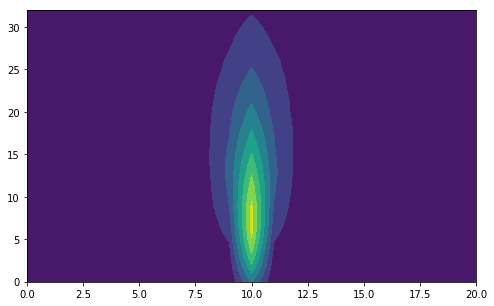

In [13]:
fig, ax = plt.subplots(figsize=(5*1.61,5))

cs = ax.contourf(CsIEnergy_buffer)
plt.show()

In [14]:
Eg = np.arange(10.0,500.1,.1)
CsIResponse_Matrix_Interp = np.zeros((len(Eg), 33))
for i in np.arange(0,33):
    CsIResponse_Matrix_Interp[:,i] = np.interp(Eg,GammaEnergy_array[:,0],CsIEnergy_YProject_array[:,i]/1e4)

In [15]:
np.shape(CsIResponse_Matrix_Interp)

(4901, 33)

## write csv file (this is for Chris B)

In [16]:
saveCSV_Bool = False;

In [17]:
if saveCSV_Bool:
    np.savetxt("CsIResponse_Matrix_Interp.csv",CsIResponse_Matrix_Interp, delimiter=",")
    np.savetxt("Eg.csv",Eg, delimiter=",")
    

# Read in ROOT Files Vertical Theta

## Find Data Files

In [18]:
check_folder = './Mangles2015_vertdiv_Dec18/'

In [19]:
dirlist = os.listdir(check_folder)
rootfiles = [check_folder+f for f in os.listdir(check_folder) if f.endswith('root')]

In [20]:
rootfiles

['./Mangles2015_vertdiv_Dec18/Gamma_040MeV_05mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_00mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_01mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_02mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_03mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_04mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_05mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_06mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_07mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_08mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_09mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_10mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_11mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_12mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_13mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_14mrad.root',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_15mrad.root',
 './Mangles2015_vertdiv_Dec18/G

In [21]:
matfiles_vtheta = []
for f in rootfiles:
    rootfilename = f
    matfilename = rootfilename[:-4] + 'mat'
    matfiles_vtheta.append(matfilename)
    if(ROOTMAT_vertdiv):
        SaveMatfile(rootfilename,matfilename);

## Read in data files

In [22]:
matfiles_vtheta

['./Mangles2015_vertdiv_Dec18/Gamma_040MeV_05mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_00mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_01mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_02mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_03mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_04mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_05mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_06mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_07mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_08mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_09mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_10mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_11mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_12mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_13mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_14mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_15mrad.mat',
 './Mangles2015_vertdiv_Dec18/Gamma_050MeV_18mra

In [23]:
mat_test = scipy.io.loadmat(matfiles[17])

CsIEnergy = mat_test['CsIEnergy'];
CsIEnergy_yaxis = mat_test['CsIEnergy_yaxis'];
CsIEnergy_xaxis = mat_test['CsIEnergy_xaxis'];
CsIEnergy_YProject = np.sum(CsIEnergy,1);

In [24]:
CsIEnergy_vtheta_yaxis_array = np.zeros((len(matfiles_vtheta),len(CsIEnergy_yaxis[0])));
CsIEnergy_vtheta_YProject_array = np.zeros((len(matfiles_vtheta),len(CsIEnergy_YProject)));
CsIEnergy_vtheta_CentralRow_array = np.zeros((len(matfiles_vtheta),len(CsIEnergy_YProject)));
GammaEnergy_vtheta_array = np.zeros((len(matfiles_vtheta),1));
VTheta_vtheta_array = np.zeros((len(matfiles_vtheta),1));

for i in range(len(matfiles_vtheta)):
    mat = scipy.io.loadmat(matfiles_vtheta[i]);
    CsIEnergy_vtheta_buffer = mat['CsIEnergy'];
    CsIEnergy_vtheta_yaxis_array[i,:] = mat['CsIEnergy_yaxis'] + 1; #this is so that the first crystal is 1
    CsIEnergy_vtheta_YProject_array[i,:] = np.sum(CsIEnergy_vtheta_buffer,1); # total sum/Y Projection of the crystal array for this column
    CsIEnergy_vtheta_CentralRow_array[i,:] = CsIEnergy_vtheta_buffer[:,10]; # only take central row instead of projecting entire array
    GammaEnergy_vtheta_array[i] = float(matfiles_vtheta[i][int(matfiles_vtheta[i].find('Gamma_'))+6:int(matfiles_vtheta[i].find('MeV'))]); # mono gamma ray energy for this simulation
    VTheta_vtheta_array[i] = float(matfiles_vtheta[i][int(matfiles_vtheta[i].find('MeV_'))+4:int(matfiles_vtheta[i].find('mrad'))]); # vertical theta for this simulation

    
energy_order = np.argsort(GammaEnergy_vtheta_array.T); # order by energy and not by file name
CsIEnergy_vtheta_yaxis_array[:,:] = CsIEnergy_vtheta_yaxis_array[energy_order,:]
CsIEnergy_vtheta_YProject_array[:,:] = CsIEnergy_vtheta_YProject_array[energy_order,:]
CsIEnergy_vtheta_CentralRow_array[:,:] = CsIEnergy_vtheta_CentralRow_array[energy_order,:]
GammaEnergy_vtheta_array[:] = GammaEnergy_vtheta_array[energy_order]
VTheta_vtheta_array[:] =  VTheta_vtheta_array[energy_order]

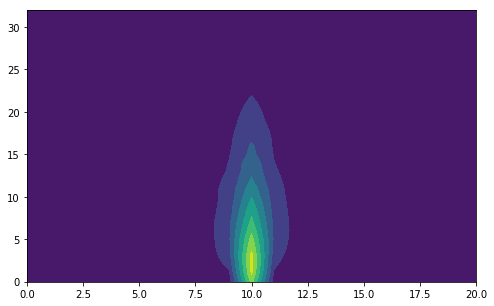

In [25]:
fig, ax = plt.subplots(figsize=(5*1.61,5))
cs = ax.contourf(CsIEnergy)
#plt.savefig('Edep_CrystalSpec_50MeV_20mrad.pdf')
plt.show()

# Reading in ROOT Files for RR2018 including profile stack

## Find Data Files

In [26]:
check_folder = './RR2018/'
dirlist = os.listdir(check_folder)
rootfiles = [check_folder+f for f in os.listdir(check_folder) if f.endswith('root')]

In [27]:
rootfiles

['./RR2018/GP_010MeV_-01mradT_-02mradP.root',
 './RR2018/GP_010MeV_-01mradT_-03mradP.root',
 './RR2018/GP_010MeV_-01mradT_-08mradP.root',
 './RR2018/GP_010MeV_-01mradT_-09mradP.root',
 './RR2018/GP_010MeV_-01mradT_-10mradP.root',
 './RR2018/GP_010MeV_-01mradT_-11mradP.root',
 './RR2018/GP_010MeV_-01mradT_-12mradP.root',
 './RR2018/GP_010MeV_-01mradT_-14mradP.root',
 './RR2018/GP_010MeV_-01mradT_-15mradP.root',
 './RR2018/GP_010MeV_-01mradT_-16mradP.root',
 './RR2018/GP_010MeV_-01mradT_-17mradP.root',
 './RR2018/GP_010MeV_-01mradT_-18mradP.root',
 './RR2018/GP_010MeV_-01mradT_-20mradP.root',
 './RR2018/GP_010MeV_-01mradT_003mradP.root',
 './RR2018/GP_010MeV_-01mradT_004mradP.root',
 './RR2018/GP_010MeV_-01mradT_005mradP.root',
 './RR2018/GP_010MeV_-01mradT_006mradP.root',
 './RR2018/GP_010MeV_-01mradT_007mradP.root',
 './RR2018/GP_010MeV_-01mradT_008mradP.root',
 './RR2018/GP_010MeV_-01mradT_009mradP.root',
 './RR2018/GP_010MeV_-01mradT_010mradP.root',
 './RR2018/GP_010MeV_-01mradT_011m

In [28]:
matfiles_profile = []
for f in rootfiles:
    rootfilename = f
    matfilename = rootfilename[:-4] + 'mat'
    matfiles_profile.append(matfilename)
    if (ROOTMAT_thetaphi):
        SaveMatfile(rootfilename,matfilename);

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 131 x 7 entries.
TrackerElec is of type TTree
Number of events: 24 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 138 x 7 entries.
TrackerElec is of type TTree
Number of events: 18 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 105 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 4

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 87 x 7 entries.
TrackerElec is of type TTree
Number of events: 23 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 104 x 7 entries.
TrackerElec is of type TTree
Number of events: 6 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 90 x 7 entries.
TrackerElec is of type TTree
Number of events: 16 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45


GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 102 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 103 x 7 entries.
TrackerElec is of type TTree
Number of events: 13 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 57 x 7 entries.
TrackerElec is of type TTree
Number of events: 18 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 45 x 7 entries.
TrackerElec is of type TTree
Number of events: 12 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 27 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 29 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
Cs

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 102 x 7 entries.
TrackerElec is of type TTree
Number of events: 20 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 42 x 7 entries.
TrackerElec is of type TTree
Number of events: 17 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 44 x 7 entries.
TrackerElec is of type TTree
Number of events: 11 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 21 x 7 entries.
TrackerElec is of type TTree
Number of events: 9 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 25 x 7 entries.
TrackerElec is of type TTree
Number of events: 9 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 24 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 93 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 30 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 34 x 7 entries.
TrackerElec is of type TTree
Number of events: 5 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 100 x 7 entries.
TrackerElec is of type TTree
Number of events: 9 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 107 x 7 entries.
TrackerElec is of type TTree
Number of events: 5 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 98 x 7 entries.
TrackerElec is of type TTree
Number of events: 14 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45


GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 81 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 35 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 36 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 33 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 81 x 7 entries.
TrackerElec is of type TTree
Number of events: 11 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 78 x 7 entries.
TrackerElec is of type TTree
Number of events: 10 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
C

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 29 x 7 entries.
TrackerElec is of type TTree
Number of events: 5 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 29 x 7 entries.
TrackerElec is of type TTree
Number of events: 6 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 93 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 38 x 7 entries.
TrackerElec is of type TTree
Number of events: 0 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 43 x 7 entries.
TrackerElec is of type TTree
Number of events: 5 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 45 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 68 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 61 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 63 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 77 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 72 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 77 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D


GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 74 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 60 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 61 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 71 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 66 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 61 x 7 entries.
TrackerElec is of type TTree
Number of events: 0 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

TrackerElec is of type TTree
Number of events: 29 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1428 x 7 entries.
TrackerElec is of type TTree
Number of events: 9 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1203 x 7 entries.
TrackerElec is of type TTree
Number of events: 19 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1209 x 7 entries.
TrackerElec is of type TTree
Number of events: 20 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of t

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 53 x 7 entries.
TrackerElec is of type TTree
Number of events: 15 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 61 x 7 entries.
TrackerElec is of type TTree
Number of events: 16 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 47 x 7 entries.
TrackerElec is of type TTree
Number of events: 8 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
C

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1952 x 7 entries.
TrackerElec is of type TTree
Number of events: 21 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 54 x 7 entries.
TrackerElec is of type TTree
Number of events: 12 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 41 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45

TrackerElec is of type TTree
Number of events: 11 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 341 x 7 entries.
TrackerElec is of type TTree
Number of events: 13 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1943 x 7 entries.
TrackerElec is of type TTree
Number of events: 11 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 47 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type

TrackerElec is of type TTree
Number of events: 33 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 569 x 7 entries.
TrackerElec is of type TTree
Number of events: 26 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 563 x 7 entries.
TrackerElec is of type TTree
Number of events: 18 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 472 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type

TrackerElec is of type TTree
Number of events: 0 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1925 x 7 entries.
TrackerElec is of type TTree
Number of events: 11 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 45 x 7 entries.
TrackerElec is of type TTree
Number of events: 6 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 47 x 7 entries.
TrackerElec is of type TTree
Number of events: 6 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH

TrackerElec is of type TTree
Number of events: 16 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 378 x 7 entries.
TrackerElec is of type TTree
Number of events: 16 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 361 x 7 entries.
TrackerElec is of type TTree
Number of events: 16 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 395 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type

TrackerElec is of type TTree
Number of events: 19 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 41 x 7 entries.
TrackerElec is of type TTree
Number of events: 6 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 45 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 46 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D

TrackerElec is of type TTree
Number of events: 14 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 48 x 7 entries.
TrackerElec is of type TTree
Number of events: 5 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 51 x 7 entries.
TrackerElec is of type TTree
Number of events: 8 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 41 x 7 entries.
TrackerElec is of type TTree
Number of events: 7 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 388 x 7 entries.
TrackerElec is of type TTree
Number of events: 19 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 397 x 7 entries.
TrackerElec is of type TTree
Number of events: 20 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 388 x 7 entries.
TrackerElec is of type TTree
Number of events: 24 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 563 x 7 entries.
TrackerElec is of type TTree
Number of events: 9 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 553 x 7 entries.
TrackerElec is of type TTree
Number of events: 11 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 35 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45


GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 439 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 448 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 444 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45


GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 47 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 44 x 7 entries.
TrackerElec is of type TTree
Number of events: 1 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 465 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
Cs

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 547 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 542 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 1967 x 7 entries.
TrackerElec is of type TTree
Number of events: 12 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 4

TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 586 x 7 entries.
TrackerElec is of type TTree
Number of events: 2 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 607 x 7 entries.
TrackerElec is of type TTree
Number of events: 6 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 610 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH

GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 53 x 7 entries.
TrackerElec is of type TTree
Number of events: 3 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 53 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsIEnergy_DESY is of type TH2D
Size: 30 x 30
TrackerGamma is of type TTree
Number of events: 53 x 7 entries.
TrackerElec is of type TTree
Number of events: 4 x 7 entries.
GunEnergy is of type TH1D
Size: 100
CsIEnergy is of type TH2D
Size: 21 x 33
CsIEnergy_Jena is of type TH2D
Size: 45 x 45
CsI

## Read in data files

In [29]:
matfiles_profile

['./RR2018/GP_010MeV_-01mradT_-02mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-03mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-08mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-09mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-10mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-11mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-12mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-14mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-15mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-16mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-17mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-18mradP.mat',
 './RR2018/GP_010MeV_-01mradT_-20mradP.mat',
 './RR2018/GP_010MeV_-01mradT_003mradP.mat',
 './RR2018/GP_010MeV_-01mradT_004mradP.mat',
 './RR2018/GP_010MeV_-01mradT_005mradP.mat',
 './RR2018/GP_010MeV_-01mradT_006mradP.mat',
 './RR2018/GP_010MeV_-01mradT_007mradP.mat',
 './RR2018/GP_010MeV_-01mradT_008mradP.mat',
 './RR2018/GP_010MeV_-01mradT_009mradP.mat',
 './RR2018/GP_010MeV_-01mradT_010mradP.mat',
 './RR2018/GP_010MeV_-01mradT_011mradP.mat',
 './RR2018

In [30]:
mat_test = scipy.io.loadmat(matfiles_profile[0])
mat_test


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Dec 25 18:37:00 2018',
 '__version__': '1.0',
 '__globals__': [],
 'GunEnergy': array([[10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,

In [53]:
CsIEnergy_Jena = mat_test['CsIEnergy_Jena'];
CsIEnergy_Jena_yaxis = mat_test['CsIEnergy_Jena_yaxis'];
CsIEnergy_Jena_xaxis = mat_test['CsIEnergy_Jena_xaxis'];

In [ ]:
CsIEnergy_Jena_yaxis_array = np.zeros((len(matfiles_profile),len(CsIEnergy_Jena[0])));
CsIEnergy_Jena_xaxis_array = np.zeros((len(matfiles_profile),len(CsIEnergy_Jena[1])));
Energy_Jena_array = np.zeros((len(matfiles_profile),1));
Theta_Jena_array = np.zeros((len(matfiles_profile),1));
Phi_Jena_array = np.zeros((len(matfiles_profile),1));

for i in range(len(matfiles_profile)):
    mat = scipy.io.loadmat(matfiles_vtheta[i]);
    CsIEnergy_vtheta_buffer = mat['CsIEnergy'];
    CsIEnergy_vtheta_yaxis_array[i,:] = mat['CsIEnergy_yaxis'] + 1; #this is so that the first crystal is 1
    Energy_vtheta_array[i] = float(matfiles_vtheta[i][int(matfiles_vtheta[i].find('Gamma_'))+6:int(matfiles_vtheta[i].find('MeV'))]); # mono gamma ray energy for this simulation
    VTheta_vtheta_array[i] = float(matfiles_vtheta[i][int(matfiles_vtheta[i].find('MeV_'))+4:int(matfiles_vtheta[i].find('mrad'))]); # vertical theta for this simulation

    
energy_order = np.argsort(GammaEnergy_vtheta_array.T); # order by energy and not by file name
CsIEnergy_vtheta_yaxis_array[:,:] = CsIEnergy_vtheta_yaxis_array[energy_order,:]
CsIEnergy_vtheta_YProject_array[:,:] = CsIEnergy_vtheta_YProject_array[energy_order,:]
CsIEnergy_vtheta_CentralRow_array[:,:] = CsIEnergy_vtheta_CentralRow_array[energy_order,:]
GammaEnergy_vtheta_array[:] = GammaEnergy_vtheta_array[energy_order]
VTheta_vtheta_array[:] =  VTheta_vtheta_array[energy_order]

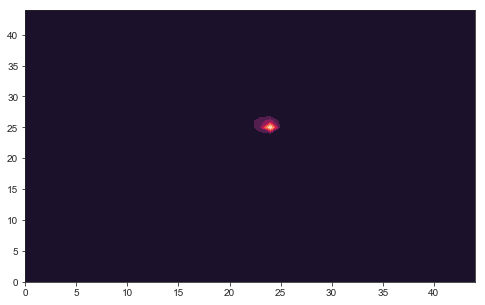

In [54]:
fig, ax = plt.subplots(figsize=(5*1.61,5))
cs = ax.contourf(CsIEnergy_Jena)
#plt.savefig('Edep_CrystalSpec_50MeV_20mrad.pdf')
plt.show()

# Plotting Simulation Results and Testing out Methods

## Plot parameters

In [33]:
# Style, should be done in a style sheet instead in the future

color_null = sns.xkcd_rgb["denim blue"];#'blue';
color_coll = sns.xkcd_rgb["orangish"];#'blue';

axis_fontsize = 22;
legends_fontsize = 18;
ticks_fontsize = 18;
ticks_yaxissci_fontsize = 16;
plot_linewidth = 3;
scatter_area = 20;

sns.set_style("ticks");

In [34]:
def dNdE_param(E,Ecrit,A=1):
    
    dNdE = A*E**(-2/3)*exp(-E/Ecrit)

    return dNdE

## Deposited Energy in Crystals (GEANT) - Zero Divergence

This is considering the total integrated response per crystal row. I could consider the central row only instead. The beam is emitted from a slim disk at divergence 1 mrad and 1 um source size. 10,000 particles were used in the simulation.

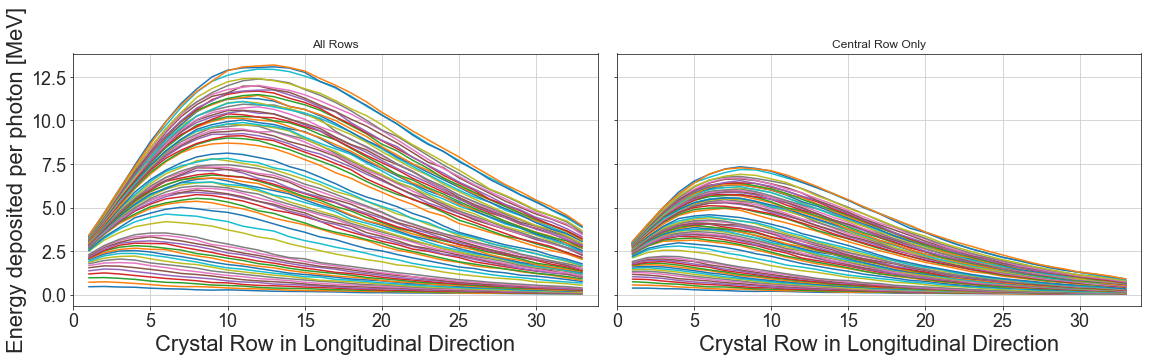

In [35]:
fig, ax = plt.subplots(1,2,figsize=(2*5*1.61,5), sharey=True)

for i in range(len(matfiles)):
    ax[0].plot(CsIEnergy_yaxis_array[i], CsIEnergy_YProject_array[i]/1e4, '-', label=GammaEnergy_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles

for i in range(len(matfiles)):
    ax[1].plot(CsIEnergy_yaxis_array[i], CsIEnergy_CentralRow_array[i]/1e4, '-', label=GammaEnergy_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles


    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax[0].set_ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
ax[1].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax[0].set_title('All Rows')
ax[1].set_title('Central Row Only')

ax[0].set_xlim((0, 34))
ax[1].set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax[0].grid(True, zorder=5)
ax[1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].tick_params(labelsize=ticks_fontsize)
ax[0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1].tick_params(labelsize=ticks_fontsize)
ax[1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('Edep_CrystalRows.pdf')
plt.show()

How does the energy deposition look for each crystal?

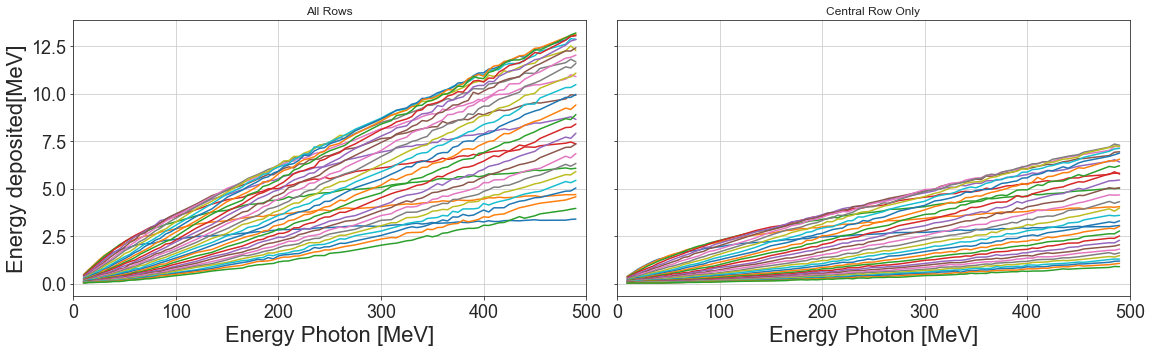

In [36]:
fig, ax = plt.subplots(1,2,figsize=(2*5*1.61,5), sharey=True)

for i in range(len(CsIEnergy_YProject_array[0,:])):
    ax[0].plot(GammaEnergy_array, CsIEnergy_YProject_array[:,i]/1e4, '-', label=i+1) # the factor 1e4 comes from the simulation which ran over 10k particles

for i in range(len(CsIEnergy_CentralRow_array[0,:])):
    ax[1].plot(GammaEnergy_array, CsIEnergy_CentralRow_array[:,i]/1e4, '-', label=i+1) # the factor 1e4 comes from the simulation which ran over 10k particles

     
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0].set_xlabel('Energy Photon [MeV]', fontsize=axis_fontsize)
ax[0].set_ylabel('Energy deposited[MeV]', fontsize=axis_fontsize)
ax[1].set_xlabel('Energy Photon [MeV]', fontsize=axis_fontsize)

#leg = ax.legend(loc='upper right', borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax[0].set_title('All Rows')
ax[1].set_title('Central Row Only')

ax[0].set_xlim((0, 500))
ax[1].set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax[0].grid(True, zorder=5)
ax[1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].tick_params(labelsize=ticks_fontsize)
ax[0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1].tick_params(labelsize=ticks_fontsize)
ax[1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('Edep_per_Crystal.pdf')
plt.show()

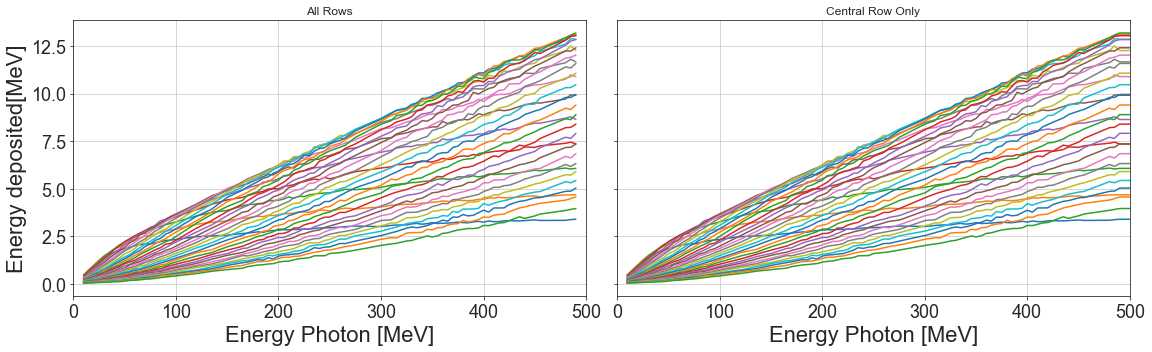

In [37]:
fig, ax = plt.subplots(1,2,figsize=(2*5*1.61,5), sharey=True)

for i in range(len(CsIEnergy_YProject_array[0,:])):
    ax[0].plot(GammaEnergy_array, CsIEnergy_YProject_array[:,i]/1e4, '-', label=i+1) # the factor 1e4 comes from the simulation which ran over 10k particles

for i in range(len(CsIEnergy_CentralRow_array[0,:])):
    ax[1].plot(Eg, CsIResponse_Matrix_Interp[:,i], '-', label=i+1) # the factor 1e4 comes from the simulation which ran over 10k particles

     
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0].set_xlabel('Energy Photon [MeV]', fontsize=axis_fontsize)
ax[0].set_ylabel('Energy deposited[MeV]', fontsize=axis_fontsize)
ax[1].set_xlabel('Energy Photon [MeV]', fontsize=axis_fontsize)

#leg = ax.legend(loc='upper right', borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax[0].set_title('All Rows')
ax[1].set_title('Central Row Only')

ax[0].set_xlim((0, 500))
ax[1].set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax[0].grid(True, zorder=5)
ax[1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].tick_params(labelsize=ticks_fontsize)
ax[0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1].tick_params(labelsize=ticks_fontsize)
ax[1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('Edep_per_Crystal.pdf')
plt.show()

## Deposited Energy in Crystals (GEANT) - non-zero divergence

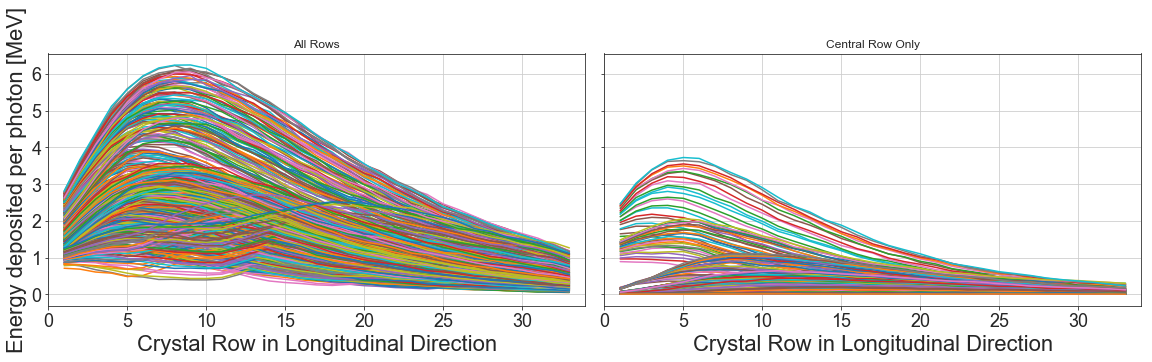

In [38]:
fig, ax = plt.subplots(1,2,figsize=(2*5*1.61,5), sharey=True)

for i in range(len(matfiles_vtheta)):
    ax[0].plot(CsIEnergy_vtheta_yaxis_array[i], CsIEnergy_vtheta_YProject_array[i]/1e4, '-', label=GammaEnergy_vtheta_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles

for i in range(len(matfiles_vtheta)):
    ax[1].plot(CsIEnergy_vtheta_yaxis_array[i], CsIEnergy_vtheta_CentralRow_array[i]/1e4, '-', label=GammaEnergy_vtheta_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles


    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax[0].set_ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
ax[1].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax[0].set_title('All Rows')
ax[1].set_title('Central Row Only')

ax[0].set_xlim((0, 34))
ax[1].set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax[0].grid(True, zorder=5)
ax[1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].tick_params(labelsize=ticks_fontsize)
ax[0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1].tick_params(labelsize=ticks_fontsize)
ax[1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('Edep_CrystalRows_nonzerodiv.pdf')
plt.show()

Since the previous plots are a bit messy, look now at one energy and the different divergences

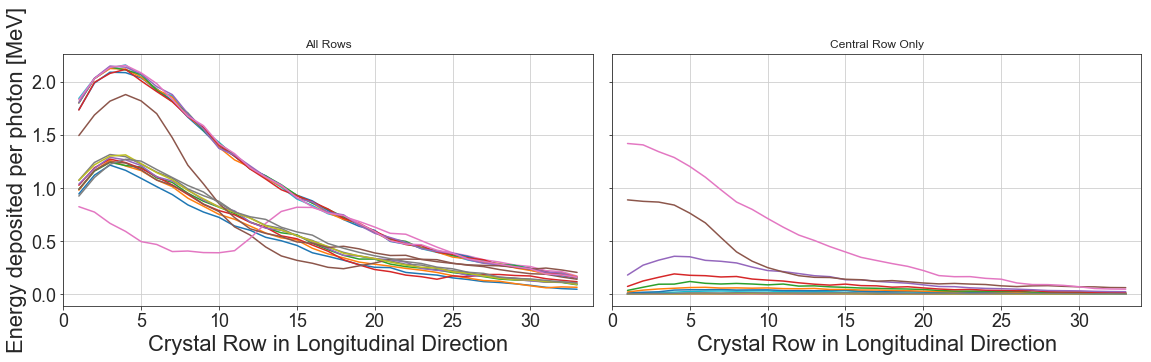

In [39]:
fig, ax = plt.subplots(1,2,figsize=(2*5*1.61,5), sharey=True)

energy_selection = 50.0;


for i in range(len(matfiles_vtheta)):
    if(GammaEnergy_vtheta_array[i]==energy_selection):
        ax[0].plot(CsIEnergy_vtheta_yaxis_array[i], CsIEnergy_vtheta_YProject_array[i]/1e4, '-', label=VTheta_vtheta_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles

for i in range(len(matfiles_vtheta)):
    if(GammaEnergy_vtheta_array[i]==energy_selection):
        ax[1].plot(CsIEnergy_vtheta_yaxis_array[i], CsIEnergy_vtheta_CentralRow_array[i]/1e4, '-', label=VTheta_vtheta_array[i]) # the factor 1e4 comes from the simulation which ran over 10k particles


    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax[0].set_ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
ax[1].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax[0].set_title('All Rows')
ax[1].set_title('Central Row Only')

ax[0].set_xlim((0, 34))
ax[1].set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax[0].grid(True, zorder=5)
ax[1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].tick_params(labelsize=ticks_fontsize)
ax[0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1].tick_params(labelsize=ticks_fontsize)
ax[1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('Edep_CrystalRows_50MeV_vdiv.pdf')
plt.show()

In [40]:
sum(GammaEnergy_vtheta_array==50.)[0]

18

## Testing Matrix Multiplication

Now testing whether I can use matrix multiplication to reproduce one of the plots.

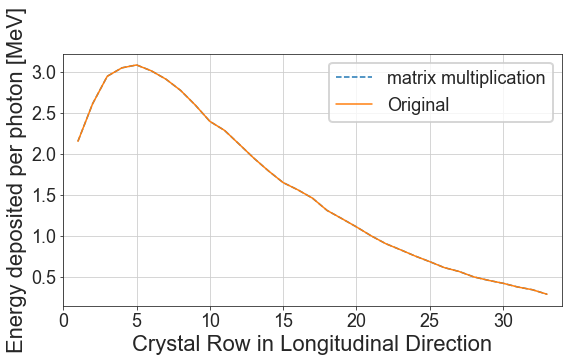

In [41]:
test_array = np.zeros((len(matfiles),1));
energy_select = 14;
test_array[energy_select] = 1.0;

fig, ax = plt.subplots(figsize=(5*1.61,5))
#for i in range(len(matfiles)):
ax.plot(CsIEnergy_yaxis_array[energy_select], np.matmul(test_array.T,CsIEnergy_YProject_array).T/1e4, '--', label='matrix multiplication')
ax.plot(CsIEnergy_yaxis_array[energy_select], CsIEnergy_YProject_array[energy_select,:]/1e4, '-', label='Original')
    
#plt.title('Mean Electron Spectra for Cole and Poder')
plt.xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
plt.ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
leg = leg.get_frame().set_linewidth(2.0)

ax.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

This appears to be successful and without any difference. Now test if you can combine several spectra.

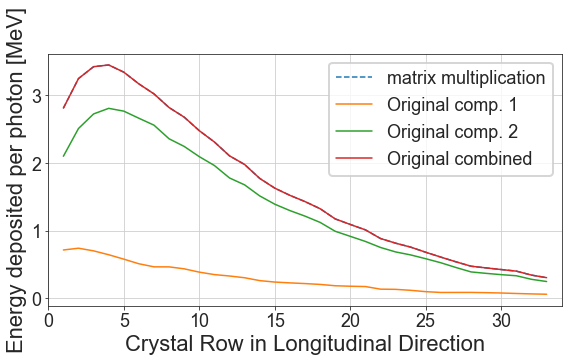

In [42]:
test_array = np.zeros((len(matfiles),1));
energy_select = [1,12];
test_array[energy_select] = 1.0;

fig, ax = plt.subplots(figsize=(5*1.61,5))
#for i in range(len(matfiles)):
ax.plot(CsIEnergy_yaxis_array[energy_select[0]], np.matmul(test_array.T,CsIEnergy_YProject_array).T/1e4, '--', label='matrix multiplication')
ax.plot(CsIEnergy_yaxis_array[energy_select[0]], CsIEnergy_YProject_array[energy_select[0],:]/1e4, '-', label='Original comp. 1')
ax.plot(CsIEnergy_yaxis_array[energy_select[1]], CsIEnergy_YProject_array[energy_select[1],:]/1e4, '-', label='Original comp. 2')
ax.plot(CsIEnergy_yaxis_array[energy_select[1]], (CsIEnergy_YProject_array[energy_select[0],:]+CsIEnergy_YProject_array[energy_select[1],:])/1e4, '-', label='Original combined')    
    
#plt.title('Mean Electron Spectra for Cole and Poder')
plt.xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
plt.ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
leg = leg.get_frame().set_linewidth(2.0)

ax.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

Now let's try out using different weights:

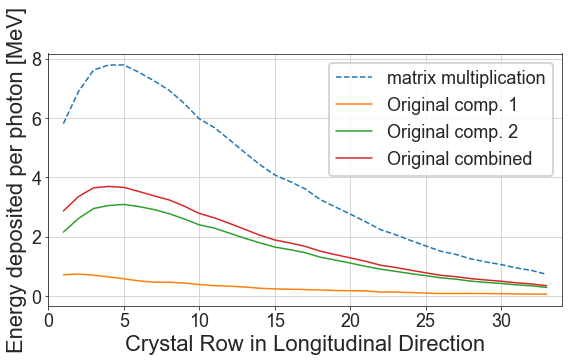

In [43]:
test_array = np.zeros((len(matfiles),1));
energy_select = [1,14];
test_array[energy_select[0]] = 1.2;
test_array[energy_select[1]] = 2.3;

fig, ax = plt.subplots(figsize=(5*1.61,5))
#for i in range(len(matfiles)):
ax.plot(CsIEnergy_yaxis_array[energy_select[0]], np.matmul(test_array.T,CsIEnergy_YProject_array).T/1e4, '--', label='matrix multiplication')
ax.plot(CsIEnergy_yaxis_array[energy_select[0]], CsIEnergy_YProject_array[energy_select[0],:]/1e4, '-', label='Original comp. 1')
ax.plot(CsIEnergy_yaxis_array[energy_select[1]], CsIEnergy_YProject_array[energy_select[1],:]/1e4, '-', label='Original comp. 2')
ax.plot(CsIEnergy_yaxis_array[energy_select[1]], (CsIEnergy_YProject_array[energy_select[0],:]+CsIEnergy_YProject_array[energy_select[1],:])/1e4, '-', label='Original combined')    
    
#plt.title('Mean Electron Spectra for Cole and Poder')
plt.xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
plt.ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
leg = leg.get_frame().set_linewidth(2.0)

ax.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

## Least Square Fits

How about reproducing a realistic spectrum? First let's look at some other parameters and decide on the shape.

How to fit to an existing shape and decide on the energy?

Select one energy and compare with least square fits of the others?

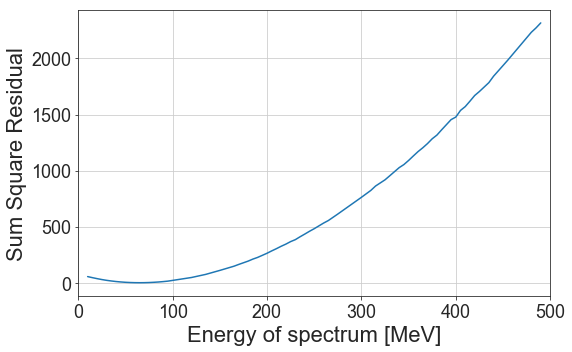

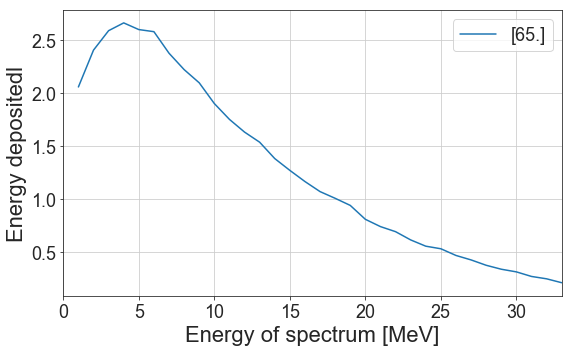

In [44]:
test_array = np.zeros((len(matfiles),1));
energy_select = 11;
test_array[energy_select] = 1.0;
response = np.matmul(test_array.T,CsIEnergy_YProject_array)/1e4;

residual_matrix = np.zeros((len(matfiles),33));
for i in range(len(matfiles)):
    residual_matrix[i] = CsIEnergy_YProject_array[i,:]/1e4 - response;
    
square_sum = np.sum(residual_matrix**2, axis=1)


fig, ax = plt.subplots(figsize=(5*1.61,5))

ax.plot(GammaEnergy_array, square_sum, '-', label='None')
    
#plt.title('Mean Electron Spectra for Cole and Poder')
plt.xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
plt.ylabel('Sum Square Residual', fontsize=axis_fontsize)
#leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax.set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()



fig, ax = plt.subplots(figsize=(5*1.61,5))
ax.plot(CsIEnergy_yaxis_array[energy_select], response.T, '-', label=GammaEnergy_array[energy_select])

plt.xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
plt.ylabel('Energy depositedl', fontsize=axis_fontsize)
leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)

ax.set_xlim((0, 33))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

For an identical plot this works. What if we have a multi-parameter fit, i.e. the shape is given but we can also vary the amplitude? We now have a 2D minimisation problem ahead of us.

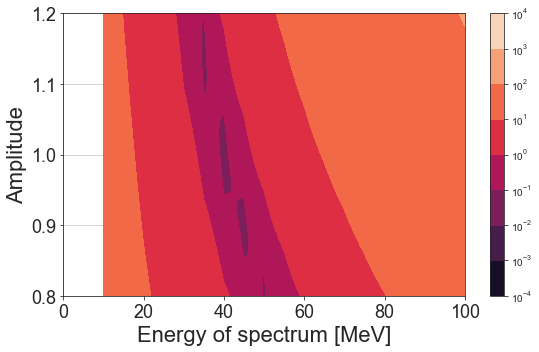

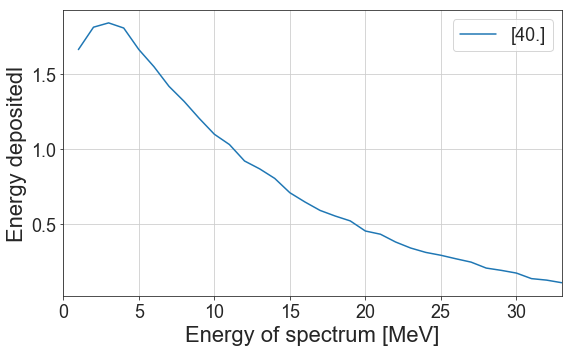

In [45]:
test_array = np.zeros((len(matfiles),1));
energy_select = 6;
test_array[energy_select] = 1.0;
response = np.matmul(test_array.T,CsIEnergy_YProject_array)/1e4;
amplitude_array = np.linspace(0.8,1.2,100);

X, Y = np.meshgrid(GammaEnergy_array,amplitude_array)

residual_matrix = np.zeros((len(matfiles),len(amplitude_array))) #np.zeros((len(matfiles),33));
for i in range(len(matfiles)):
    for j in range(len(amplitude_array)):
        residual_matrix[i,j] = np.sum((amplitude_array[j]*CsIEnergy_YProject_array[i,:]/1e4 - response)**2,axis=1)
        
    
fig, ax = plt.subplots(figsize=(5*1.61,5))

cs = ax.contourf(X,Y,residual_matrix.T, locator=tck.LogLocator())


plt.xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
plt.ylabel('Amplitude', fontsize=axis_fontsize)
#leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax.set_xlim((0, 100))
ax.set_ylim((min(amplitude_array), max(amplitude_array)))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
cbar = fig.colorbar(cs)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()



fig, ax = plt.subplots(figsize=(5*1.61,5))
ax.plot(CsIEnergy_yaxis_array[energy_select], response.T, '-', label=GammaEnergy_array[energy_select])

plt.xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
plt.ylabel('Energy depositedl', fontsize=axis_fontsize)
leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)

ax.set_xlim((0, 33))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

In [46]:
np.shape(residual_matrix)

(72, 100)

What is the total energy deposited per photon?

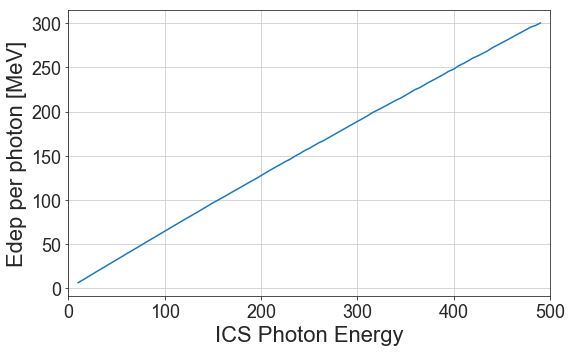

In [47]:
fig, ax = plt.subplots(figsize=(5*1.61,5))
Edep_array = np.zeros((len(matfiles),1))

for i in range(len(matfiles)):
    Edep_array[i] = np.sum(CsIEnergy_YProject_array[i]/1e4);
    
ax.plot(GammaEnergy_array, Edep_array, '-')

    
#plt.title('Mean Electron Spectra for Cole and Poder')
plt.xlabel('ICS Photon Energy', fontsize=axis_fontsize)
plt.ylabel('Edep per photon [MeV]', fontsize=axis_fontsize)
#leg = ax.legend(bbox_to_anchor=(1., 1.02, 1., .102), loc='upper right', ncol=2, mode="expand", borderaxespad=0.,fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

ax.set_xlim((0, 500))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
plt.savefig('Edep_TotalMeV.pdf')
plt.show()

This is basically a factor of 2. Where does the other half of the energy go? Is that all deposited in the spacers or does it take into account the emission sideways in the scintillator?

If we assume a spectrum, e.g. exponential with another E factor. How does that look:

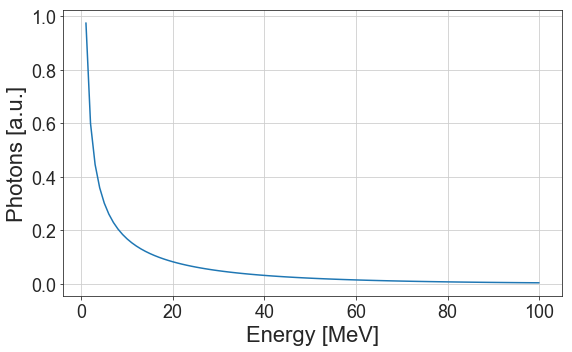

In [48]:
EnergyAxis = np.linspace(1, 100, 100)

fig, ax = plt.subplots(figsize=(5*1.61,5))
line1, = ax.plot(EnergyAxis, dNdE_param(EnergyAxis,40), '-')
        
#plt.title('Mean Electron Spectra for Cole and Poder')
plt.xlabel('Energy [MeV]', fontsize=axis_fontsize)
plt.ylabel('Photons [a.u.]', fontsize=axis_fontsize)
#leg = ax.legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
#leg = leg.get_frame().set_linewidth(2.0)

#x.set_xlim((0, 34))
#x.set_ylim((0, 0.004))
ax.grid(True, zorder=5)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=ticks_fontsize)
ax.yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Comparison_ESpectra.pdf')
plt.show()

This requires a few more simulations to get a proper grid of energies

In [49]:
energy_select = 6; # select a critical energy

test_ecrit = GammaEnergy_array[energy_select];
print(test_ecrit)
test_array = np.zeros((len(matfiles),1));

# fill test array, for now use discrete points that were simulated
test_array = dNdE_param(GammaEnergy_array,test_ecrit)
response = np.matmul(test_array.T,CsIEnergy_YProject_array)/1e4;

# Try to find the residual fit
amplitude_array = np.linspace(.1,2.0,100);
ecrit_array = np.linspace(10.0, 110.0, 100);

# mono-energetic fit
X_mono, Y_mono = np.meshgrid(GammaEnergy_array,amplitude_array)
residual_matrix_mono = np.zeros((len(matfiles),len(amplitude_array))) #np.zeros((len(matfiles),33));
for i in range(len(matfiles)):
    for j in range(len(amplitude_array)):
        residual_matrix_mono[i,j] = np.sum((amplitude_array[j]*CsIEnergy_YProject_array[i,:]/1e4 - response)**2,axis=1)

# critical energy exponential fit
residual_matrix_spec = np.zeros((len(ecrit_array),len(amplitude_array))) #np.zeros((len(matfiles),33));
guess_response = []
X_spec, Y_spec = np.meshgrid(ecrit_array,amplitude_array)
for i in range(len(ecrit_array)):
    guess_response =  np.matmul(dNdE_param(GammaEnergy_array,ecrit_array[i]).T,CsIEnergy_YProject_array)/1e4;
    for j in range(len(amplitude_array)):
        residual_matrix_spec[i,j] = np.sum((amplitude_array[j]*guess_response - response)**2,axis=1)

[40.]


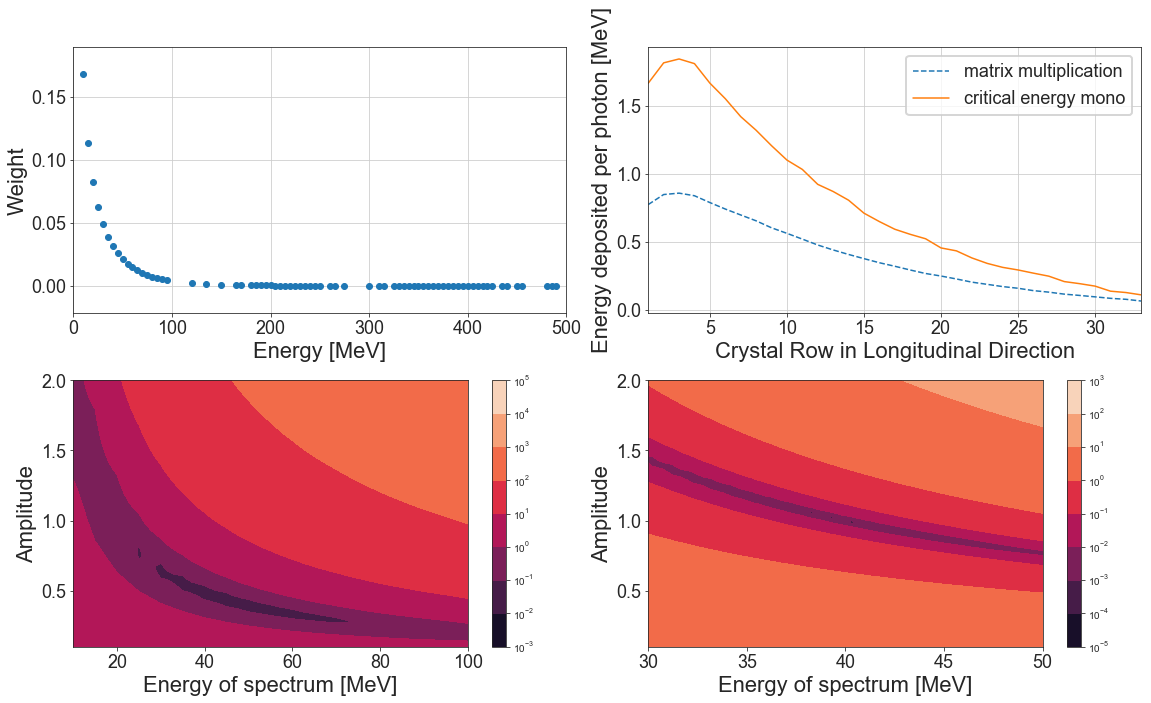

In [50]:


### Plot
fig, ax = plt.subplots(2,2,figsize=(2*5*1.61,2*5))

scatter1 = ax[0,0].scatter(GammaEnergy_array, test_array);

line1, = ax[0,1].plot(CsIEnergy_yaxis_array[0], response.T, '--', label='matrix multiplication')
line2, = ax[0,1].plot(CsIEnergy_yaxis_array[0], CsIEnergy_YProject_array[energy_select,:]/1e4, '-', label='critical energy mono') 
cs1 = ax[1,0].contourf(X_mono,Y_mono,residual_matrix_mono.T, locator=tck.LogLocator())  
cbar1 = fig.colorbar(cs1, ax=ax[1,0])
cs2 = ax[1,1].contourf(X_spec,Y_spec,residual_matrix_spec.T, locator=tck.LogLocator())   
cbar2 = fig.colorbar(cs2, ax=ax[1,1])
    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0,1].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax[0,1].set_ylabel('Energy deposited per photon [MeV]', fontsize=axis_fontsize)
ax[0,0].set_xlabel('Energy [MeV]', fontsize=axis_fontsize)
ax[0,0].set_ylabel('Weight', fontsize=axis_fontsize)
ax[1,0].set_xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
ax[1,0].set_ylabel('Amplitude', fontsize=axis_fontsize)
ax[1,1].set_xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
ax[1,1].set_ylabel('Amplitude', fontsize=axis_fontsize)

leg = ax[0,1].legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
leg = leg.get_frame().set_linewidth(2.0)

ax[0,1].set_xlim((1, 33))
ax[0,0].set_xlim((0,500))
ax[1,0].set_xlim((10,100))
ax[1,1].set_xlim((30,50))
#x.set_ylim((0, 0.004))
ax[0,0].grid(True, zorder=5)
ax[0,1].grid(True, zorder=5)
ax[1,0].grid(True, zorder=5)
ax[1,1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].tick_params(labelsize=ticks_fontsize)
ax[0,1].tick_params(labelsize=ticks_fontsize)
ax[1,0].tick_params(labelsize=ticks_fontsize)
ax[1,1].tick_params(labelsize=ticks_fontsize)
ax[0,0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[0,1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1,0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1,1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

This seems to work resonably well. Now we have to consider what we have to do for a full spectrum without 5 MeV but 1 MeV steps. Now we have to interpolate the response between the steps I have simulated. I ran simulations for mono-energetic gamma rays, is the bin 1 MeV or actually infinitely thin. Summing up a spectrum by adding a response every 1 MeV or do we require finer steps?

Steps to undertake: 
1. write code to interpolate for arbitrary photon energies
2. write code to make spectra and responses on arbitrary photon energies
3. write code to minimise this instead of least square
4. write code to add a constant background 
5. REAL DATA 2015: check for correction factor due to vignetting and imperfect crystal
6. REAL DATA 2015: bremsstrahlung data
7. REAL DATA 2015: normal shot ICS
8. adjust simulation for BW 2018
9. re-run simulations nad fitting routines for BW 2018

## Arbitrary Interpolated Energy Steps

Now do the same with a finer spectrum for an arbitrary energy selection:



In [51]:
test_ecrit = 43.1; # as always in MeV
print(test_ecrit)
# now use Eg as array and CsIResponse_Matrix_Interp as response matrix
test_array = np.zeros((len(Eg),1));

# fill test array with grid as interpolated earlier in Eg/CsIResponse_Matrix_Interp
test_array = dNdE_param(Eg,test_ecrit)
response = np.matmul(test_array.T,CsIResponse_Matrix_Interp);

# Try to find the residual fit
amplitude_array = np.linspace(.1,2.0,100);
ecrit_array = np.linspace(10.0, 110.0, 100);

# critical energy exponential fit
residual_matrix_spec = np.zeros((len(ecrit_array),len(amplitude_array))) #np.zeros((len(matfiles),33));
guess_response = []
X_spec, Y_spec = np.meshgrid(ecrit_array,amplitude_array)
for i in range(len(ecrit_array)):
    guess_response =  np.matmul(dNdE_param(Eg,ecrit_array[i]).T,CsIResponse_Matrix_Interp);
    for j in range(len(amplitude_array)):
        residual_matrix_spec[i,j] = np.sum((amplitude_array[j]*guess_response - response)**2,axis=0)

43.1


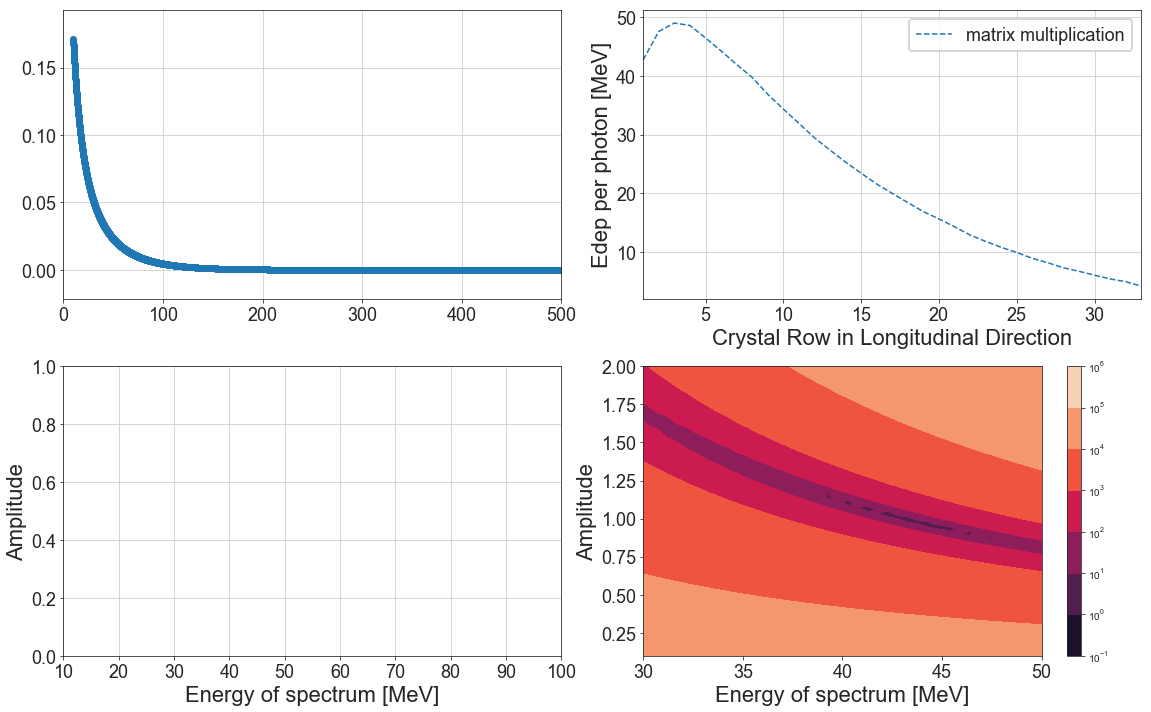

In [52]:


### Plot
fig, ax = plt.subplots(2,2,figsize=(2*5*1.61,2*5))

scatter1 = ax[0,0].scatter(Eg, test_array);

line1, = ax[0,1].plot(CsIEnergy_yaxis_array[0], response.T, '--', label='matrix multiplication')
cs2 = ax[1,1].contourf(X_spec,Y_spec,residual_matrix_spec.T, locator=tck.LogLocator())   
cbar2 = fig.colorbar(cs2, ax=ax[1,1])
    
#plt.title('Mean Electron Spectra for Cole and Poder')
ax[0,1].set_xlabel('Crystal Row in Longitudinal Direction', fontsize=axis_fontsize)
ax[0,1].set_ylabel('Edep per photon [MeV]', fontsize=axis_fontsize)
ax[1,0].set_xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
ax[1,0].set_ylabel('Amplitude', fontsize=axis_fontsize)
ax[1,1].set_xlabel('Energy of spectrum [MeV]', fontsize=axis_fontsize)
ax[1,1].set_ylabel('Amplitude', fontsize=axis_fontsize)

leg = ax[0,1].legend(loc='upper right', fontsize=legends_fontsize, frameon=True)
leg = leg.get_frame().set_linewidth(2.0)

ax[0,1].set_xlim((1, 33))
ax[0,0].set_xlim((0,500))
ax[1,0].set_xlim((10,100))
ax[1,1].set_xlim((30,50))
#x.set_ylim((0, 0.004))
ax[0,0].grid(True, zorder=5)
ax[0,1].grid(True, zorder=5)
ax[1,0].grid(True, zorder=5)
ax[1,1].grid(True, zorder=5)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].tick_params(labelsize=ticks_fontsize)
ax[0,1].tick_params(labelsize=ticks_fontsize)
ax[1,0].tick_params(labelsize=ticks_fontsize)
ax[1,1].tick_params(labelsize=ticks_fontsize)
ax[0,0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[0,1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1,0].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)
ax[1,1].yaxis.offsetText.set_fontsize(ticks_yaxissci_fontsize)

plt.tight_layout()
#plt.savefig('Edep_CrystalRows.pdf')
plt.show()

# Corrections for real data

There were two main corrections to apply to match the real data with the simulations:
1. take Bremsstrahlung data and match response of detector to simulation to get rid of vignetting etc.
2. take Bremsstrahlung data and match good or bad pixels.

For this I have to look at the real Brems spectrum AND run simulations with a converter and a real electron spectrometer.